In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
from environments import EnvironmentModel1 as Environment
from environments import translate_action_model1 as translate_action
from environments import reward_scaler_model1 as reward_scaler
from environments import STATES_MU1, STATES_SIGMA1
from environments.model1 import scale_states

In [4]:
from agents.new_dqnagent import Agent

Using TensorFlow backend.


In [5]:
size_multiplier = 0.7
FIGSIZE = (14*size_multiplier, 8*size_multiplier)
EPISODES = 300

In [6]:
lr = 0.0005
agent = Agent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=5,
              n_actions=4, mem_size=1000000, batch_size=64, epsilon_dec=0.9999,
              epsilon_end=0.01, state_scaler_mu = STATES_MU1,
              state_scaler_sigma = STATES_SIGMA1)

In [7]:
agent.load_model('models//dqn_model')

In [8]:
def random_action():
    act = np.random.randint(0, 4)
    return [0, 25, 37, 45][act]


# Beta_L = 2

In [9]:
parameters = {
    'beta_L' : 2,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'omega': 3.5,
}

env = Environment(**parameters)

results_sim = list()
total_score_sim = list()

for episode in range(200):
    if episode % 10 == 0:
        print('Episode:', episode)
    beta_L = 4
    state = env.reset(parameters={'beta_L': beta_L})
    
    done, G = False, 0
    while done is False:
        
        action = agent.choose_action(state)
        _action = transform_action(action)
        new_state, reward, done, info = env.step(_action)
        scaled_reward = reward_scaler(reward, beta_L)
        agent.epsilon = 0.0
        state = new_state
        
        G += scaled_reward
        results_sim.append(create_return_array(state, _action, scaled_reward, episode))
    
    total_score_sim.append(G)
    
    if episode % 50 == 0:
        plt.plot(total_score_sim)
        plt.plot(pd.Series(total_score_sim).rolling(50).mean())
        plt.show()

In [10]:
rewards_history, action_history = list(), list()

for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        action = agent.choose_action(state)
        _action = translate_action(action)
        next_state, reward, done, _ = env.step(_action)
        scaled_reward = (reward - 24 ) / 5

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
            break

df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])

In [11]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = random_action()
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break
            
df_random_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [12]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 0
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_0_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [13]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 37
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_37_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [14]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 45
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_45_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

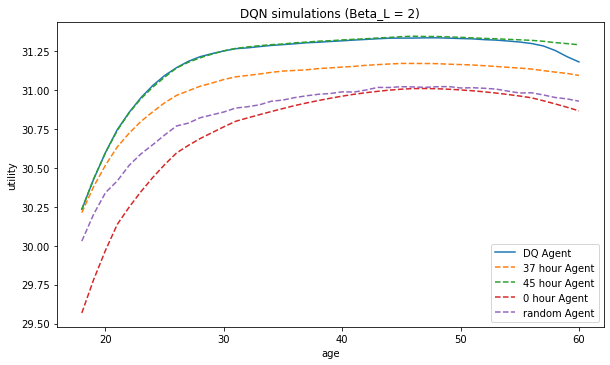

In [15]:
f, ax = plt.subplots(1, 1, figsize = FIGSIZE)
ax.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label='DQ Agent')
ax.plot(df_37_agent.drop('episode', axis=1).groupby('Q').mean(), label='37 hour Agent', ls='--')
ax.plot(df_45_agent.drop('episode', axis=1).groupby('Q').mean(), label='45 hour Agent', ls='--')
ax.plot(df_0_agent.drop('episode', axis=1).groupby('Q').mean(), label='0 hour Agent', ls='--')
ax.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='random Agent', ls='--')


ax.legend()
ax.set_xlabel('age')
ax.set_ylabel('utility')
ax.set_title('DQN simulations (Beta_L = 2)')
f.savefig('..//figures//dqn_model1_beta_2_solution_benchmark_paths')

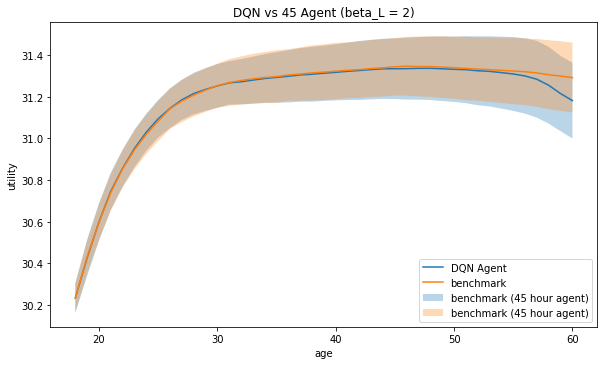

In [16]:
f, ax = plt.subplots(1, 1, figsize = FIGSIZE)

compare_df = df_45_agent
agent_name = 'DQN Agent'
benchmark_name = 'benchmark (45 hour agent)'

ax.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label=agent_name)
upper_bound = df_DQAgent.drop('episode', axis=1).groupby('Q').mean() + df_DQAgent.drop('episode', axis=1).groupby('Q').std()
lower_bound = df_DQAgent.drop('episode', axis=1).groupby('Q').mean() - df_DQAgent.drop('episode', axis=1).groupby('Q').std()
ax.fill_between(range(18,61), upper_bound['rewards'], lower_bound["rewards"], alpha=0.3, label=benchmark_name)


ax.plot(compare_df.drop('episode', axis=1).groupby('Q').mean(), label='benchmark')
upper_bound = compare_df.drop('episode', axis=1).groupby('Q').mean() + compare_df.drop('episode', axis=1).groupby('Q').std()
lower_bound = compare_df.drop('episode', axis=1).groupby('Q').mean() - compare_df.drop('episode', axis=1).groupby('Q').std()
ax.fill_between(range(18,61), upper_bound['rewards'], lower_bound["rewards"], alpha=0.3, label=benchmark_name)

plt.legend(loc='lower right')
ax.set_xlabel('age')
ax.set_ylabel('utility')

ax.set_title('DQN vs 45 Agent (beta_L = 2)')
f.savefig('..//figures//dqn_model1_beta_2_solution_benchmark_variance')

# Beta_L = 4

In [17]:
parameters = {
    'beta_L' : 4,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'omega': 3.5,
}

env = Environment(**parameters)



In [18]:
rewards_history, action_history = list(), list()
agent.epsilon=0.0

for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        action = agent.choose_action(state)
        _action = translate_action(action)
        next_state, reward, done, _ = env.step(_action)
        scaled_reward = (reward - 24 ) / 5

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
            break

df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])

In [19]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = random_action()
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break
            
df_random_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [20]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 0
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_0_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [21]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 37
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_37_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [22]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 45
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_45_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

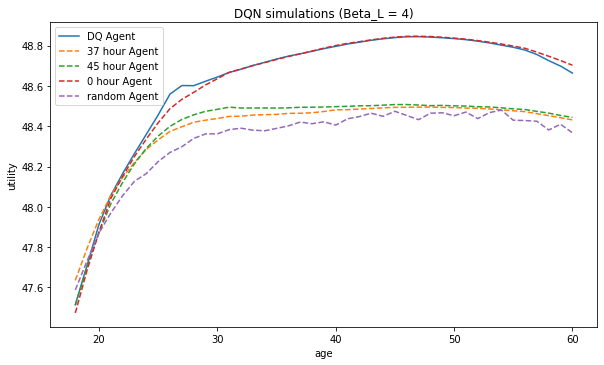

In [23]:
f, ax = plt.subplots(1, 1, figsize = FIGSIZE)
ax.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label='DQ Agent')
ax.plot(df_37_agent.drop('episode', axis=1).groupby('Q').mean(), label='37 hour Agent', ls='--')
ax.plot(df_45_agent.drop('episode', axis=1).groupby('Q').mean(), label='45 hour Agent', ls='--')
ax.plot(df_0_agent.drop('episode', axis=1).groupby('Q').mean(), label='0 hour Agent', ls='--')
ax.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='random Agent', ls='--')


ax.legend()
ax.set_xlabel('age')
ax.set_ylabel('utility')
ax.set_title('DQN simulations (Beta_L = 4)')
f.savefig('..//figures//dqn_model1_beta_4_solution_benchmark_paths')

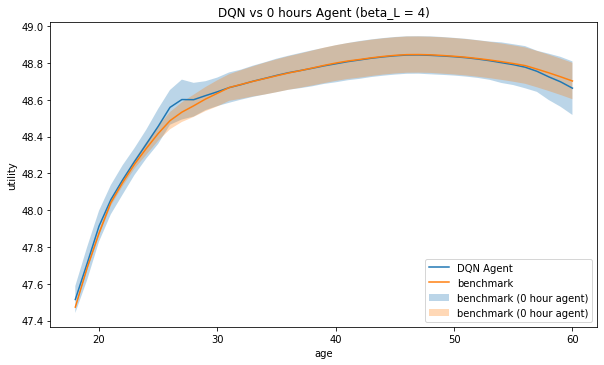

In [24]:
f, ax = plt.subplots(1, 1, figsize = FIGSIZE)

compare_df = df_0_agent
agent_name = 'DQN Agent'
benchmark_name = 'benchmark (0 hour agent)'

ax.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label=agent_name)
upper_bound = df_DQAgent.drop('episode', axis=1).groupby('Q').mean() + df_DQAgent.drop('episode', axis=1).groupby('Q').std()
lower_bound = df_DQAgent.drop('episode', axis=1).groupby('Q').mean() - df_DQAgent.drop('episode', axis=1).groupby('Q').std()
ax.fill_between(range(18,61), upper_bound['rewards'], lower_bound["rewards"], alpha=0.3, label=benchmark_name)


ax.plot(compare_df.drop('episode', axis=1).groupby('Q').mean(), label='benchmark')
upper_bound = compare_df.drop('episode', axis=1).groupby('Q').mean() + compare_df.drop('episode', axis=1).groupby('Q').std()
lower_bound = compare_df.drop('episode', axis=1).groupby('Q').mean() - compare_df.drop('episode', axis=1).groupby('Q').std()
ax.fill_between(range(18,61), upper_bound['rewards'], lower_bound["rewards"], alpha=0.3, label=benchmark_name)

plt.legend(loc='lower right')
ax.set_xlabel('age')
ax.set_ylabel('utility')

ax.set_title('DQN vs 0 hours Agent (beta_L = 4)')
f.savefig('..//figures//dqn_model1_beta_4_solution_benchmark_variance')